In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import cv2 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
paths = {
    'train': r'F:\Datasets\images\train',
    'test': r'F:\Datasets\images\final test',
    'val': r'F:\Datasets\images\validation'
}

categories = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

filenames_list = []
categories_list = []

for category in categories:
    path = os.path.join(paths['train'], categories[category])
    filenames = os.listdir(path)
    for filename in filenames:
        filenames_list.append(os.path.join(categories[category], filename))
    categories_list = categories_list + [category]*len(filenames)

df = pd.DataFrame({'filename': filenames_list, 'category': categories_list})
df = df.sample(frac = 1).reset_index(drop=True)

df

,filename,category
0,fear\23213.jpg,2
1,sad\35262.jpg,5
2,happy\32641.jpg,3
3,sad\23509.jpg,5
4,neutral\21257.jpg,4
...,...,...
26916,neutral\3856.jpg,4
26917,neutral\15933.jpg,4
26918,angry\32751.jpg,0
26919,fear\3432.jpg,2


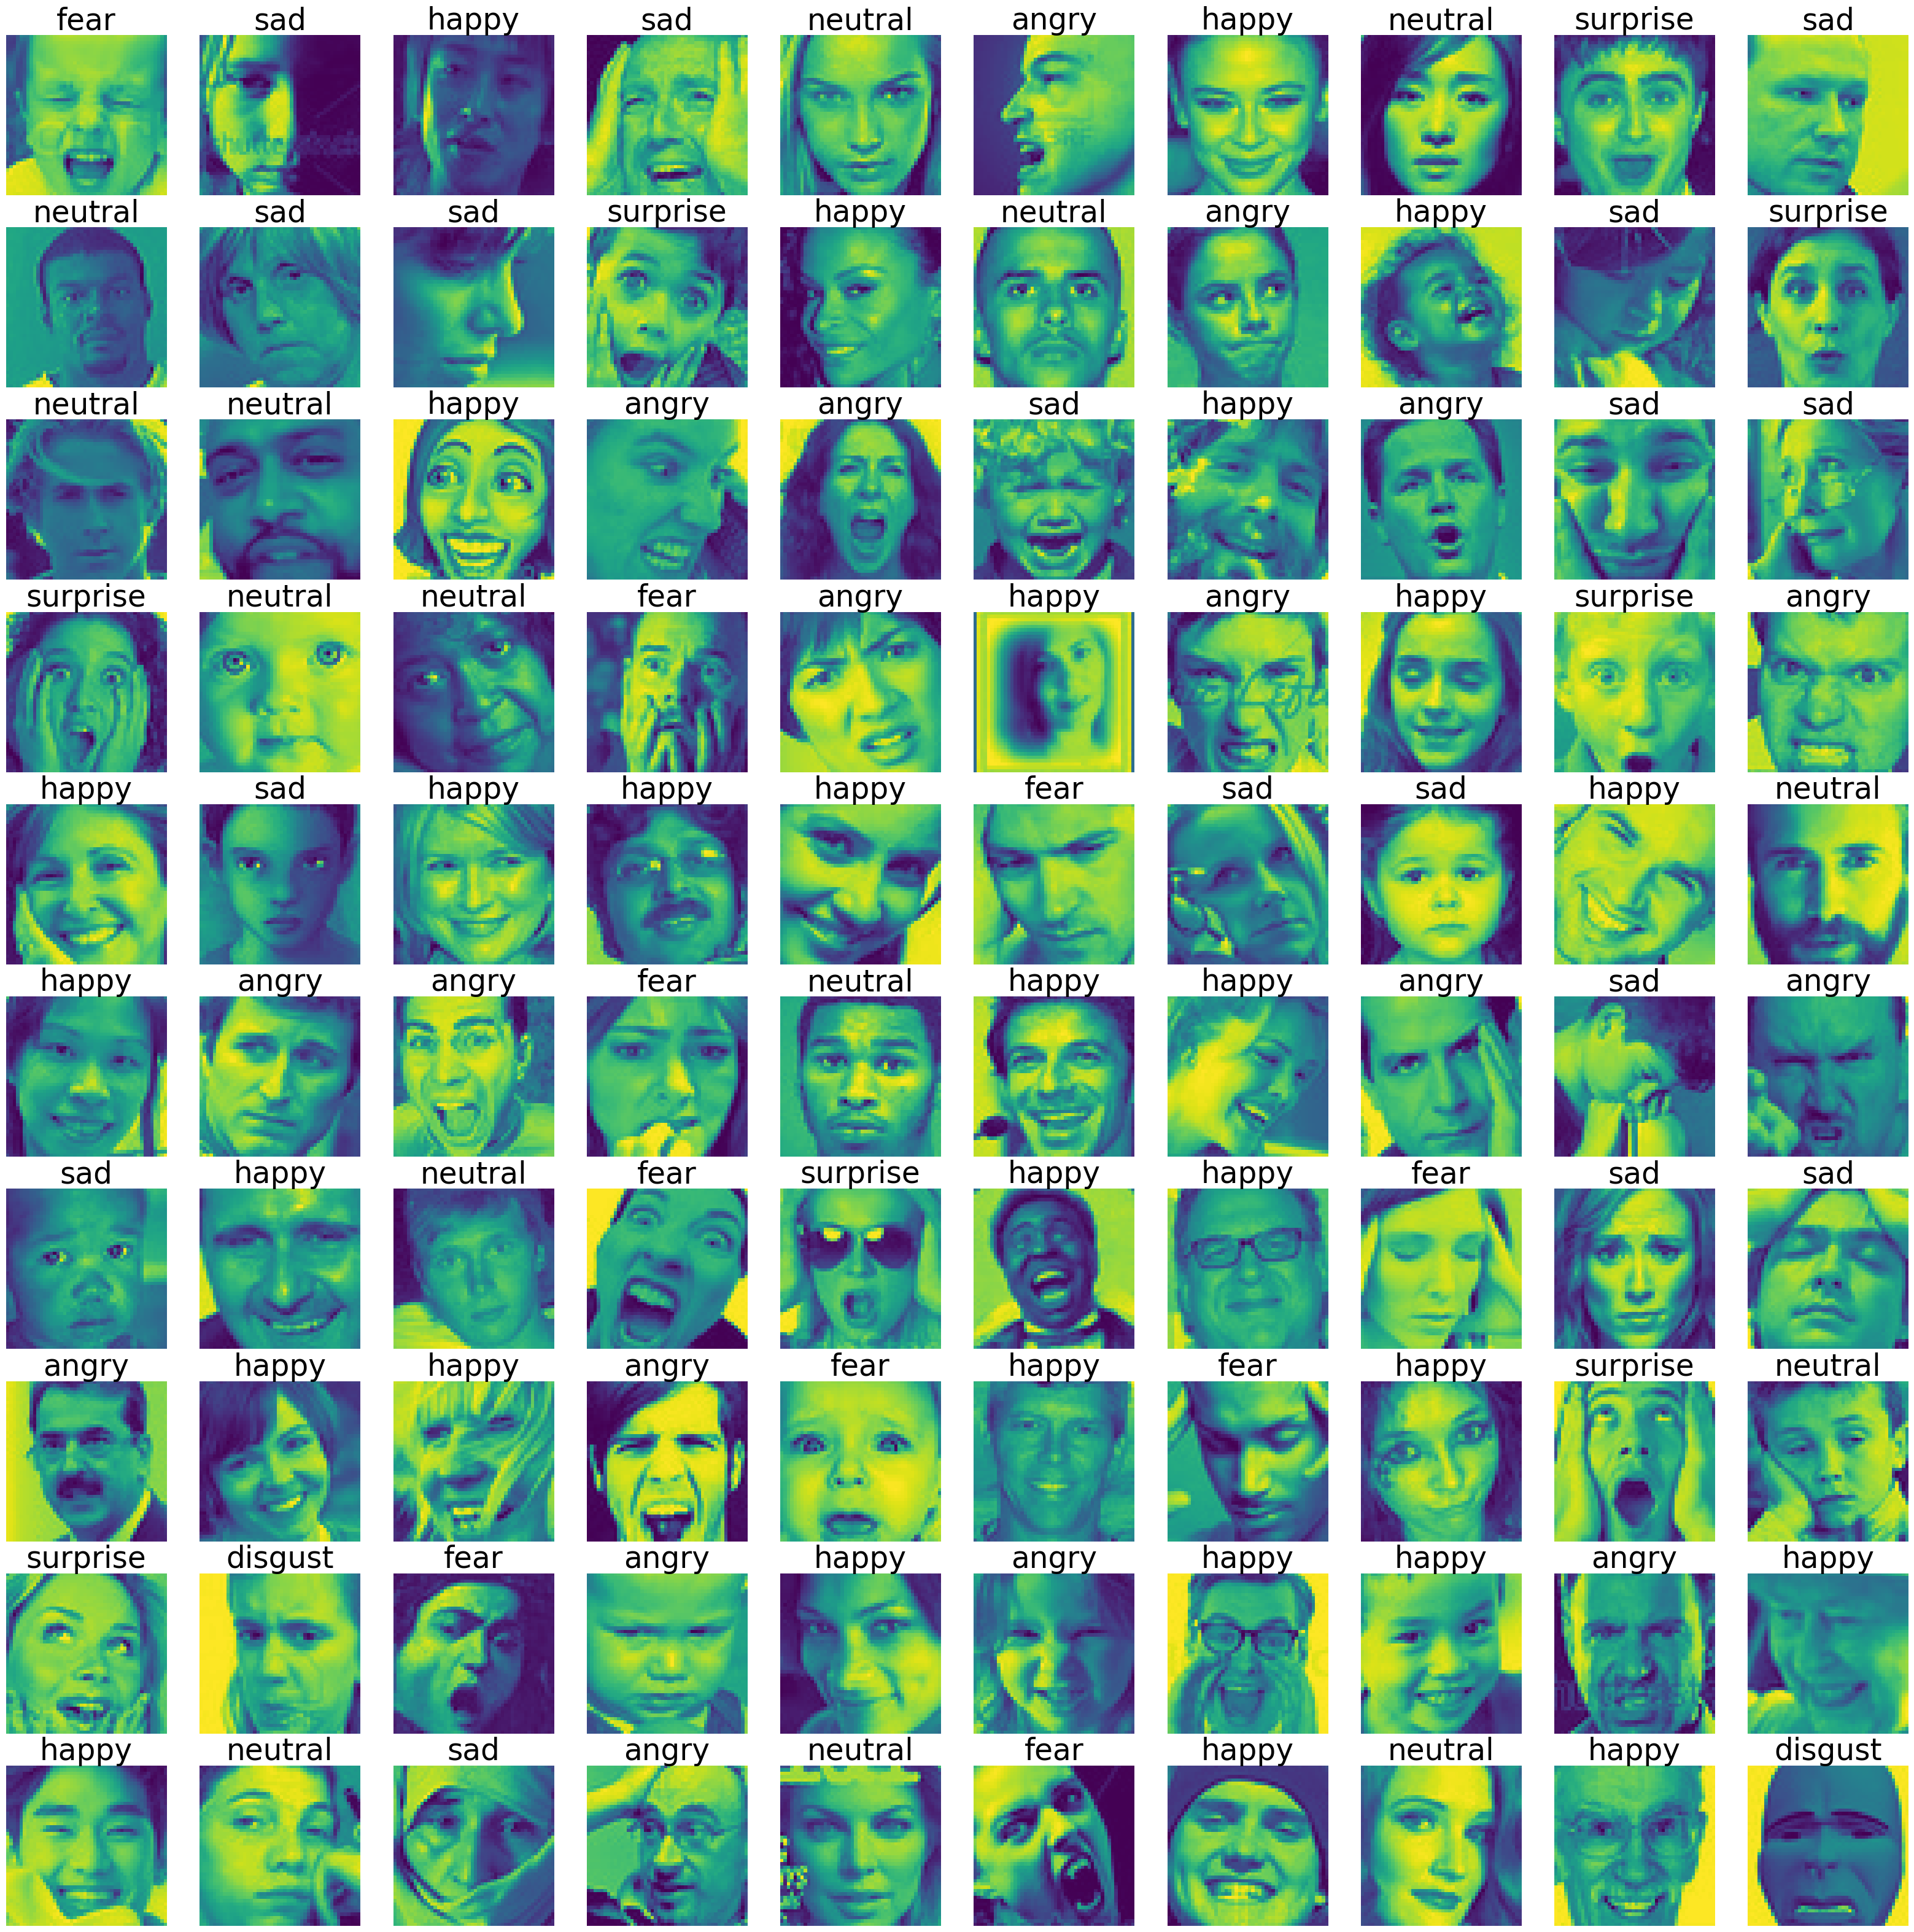

In [3]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = os.path.join(paths['train'], df.filename[i])
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35)
    plt.axis("off")

C:\Users\suyog\AppData\Local\Temp\ipykernel_15676\1517886089.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)


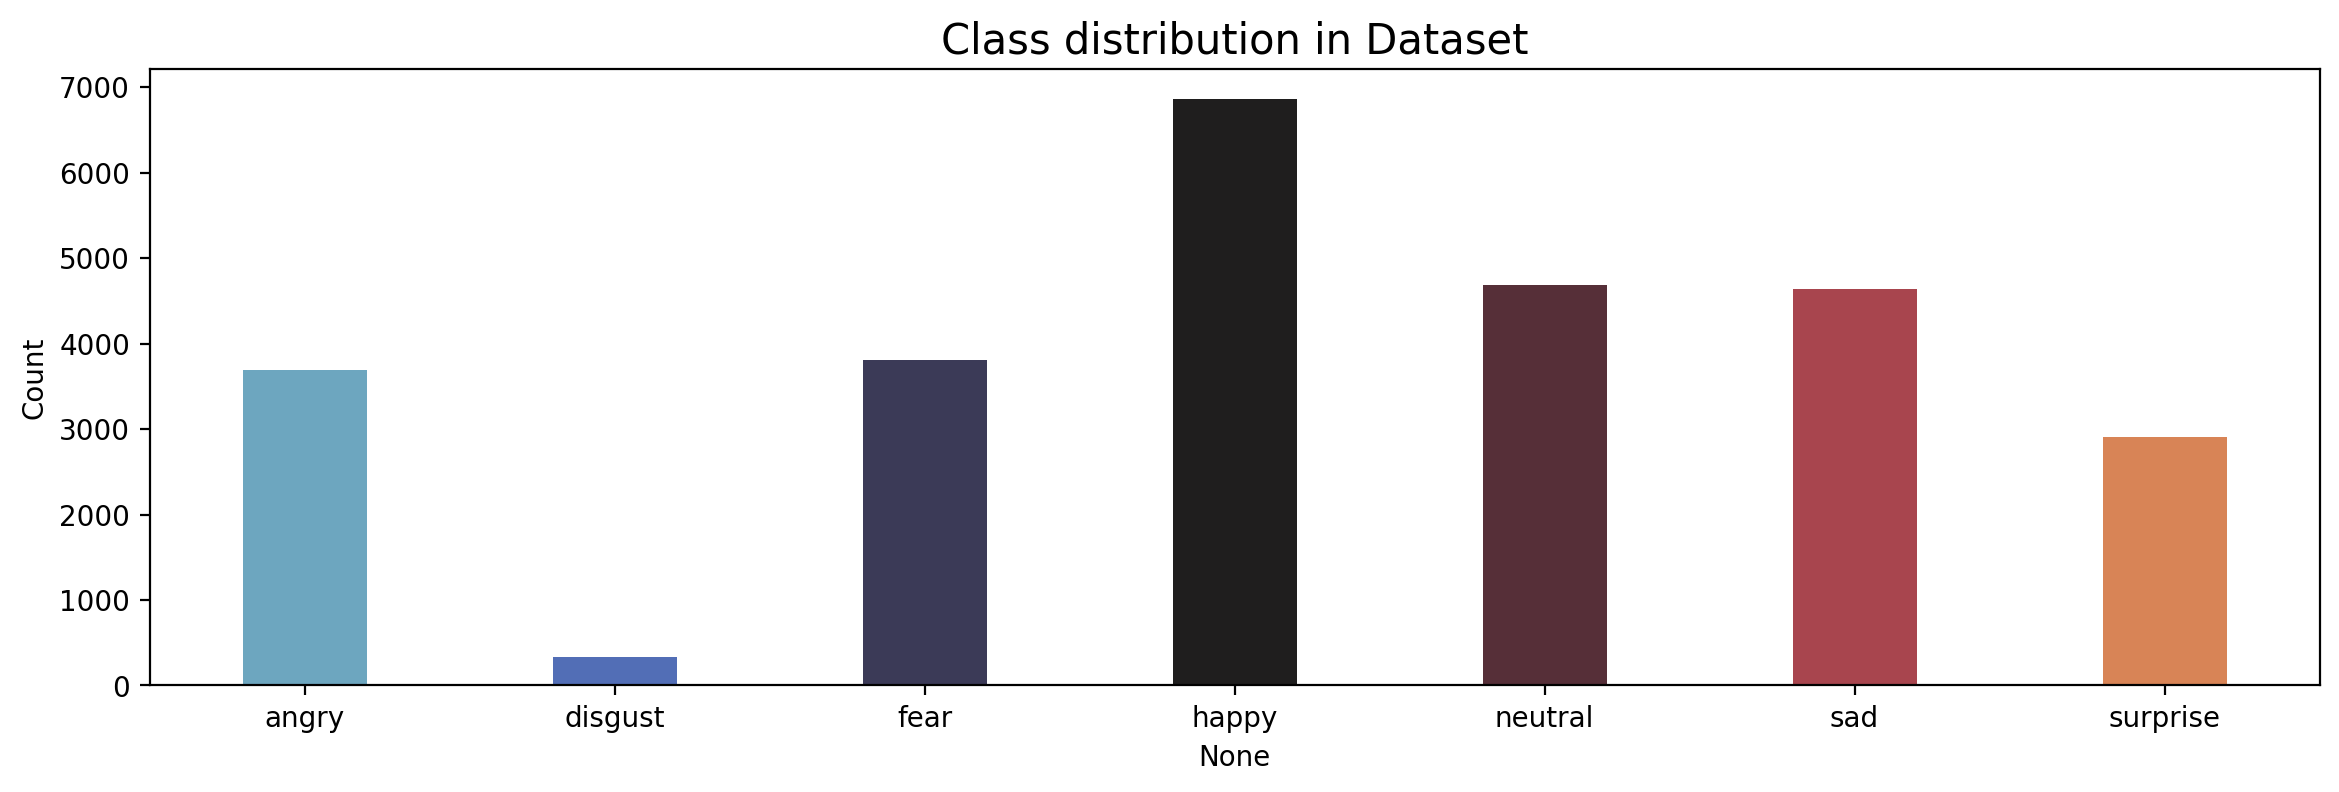

In [4]:
label, count = np.unique(df.category, return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

In [5]:
datagen = ImageDataGenerator(rescale = 1.0/255)

In [6]:
train_path = paths['train']
test_path = paths['test']
val_path = paths['val']

batch_size = 128
image_size = 48
img_channel = 1
n_classes = 7

In [7]:
train_data = datagen.flow_from_directory(train_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         color_mode='grayscale',
                                         class_mode= 'categorical',
                                         shuffle=True)

test_data = datagen.flow_from_directory(test_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         color_mode='grayscale',
                                         class_mode= 'categorical',
                                         shuffle=True)

val_data = datagen.flow_from_directory(val_path,
                                         batch_size = batch_size,
                                         target_size=(image_size, image_size),
                                         color_mode='grayscale',
                                         class_mode= 'categorical',
                                         shuffle=True)

Found 26921 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
inp = tf.keras.layers.Input(shape=(image_size,image_size,img_channel))

model = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(inp)
#model = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

#model = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

#model = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu')(model)
model = tf.keras.layers.MaxPool2D(padding='same')(model)
model = tf.keras.layers.Dropout(0.2)(model)

model = tf.keras.layers.Flatten()(model)

model = tf.keras.layers.Dense(512, activation='relu')(model)
model = tf.keras.layers.Dropout(0.2)(model)
model = tf.keras.layers.Dense(128, activation='relu')(model)
model = tf.keras.layers.Dropout(0.3)(model)

out = tf.keras.layers.Dense(n_classes, activation='softmax')(model)

model = tf.keras.Model(inputs = [inp], outputs = out)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 128)       0         
 g2D)                                                      

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta= 0.001,
                                                  patience=5,
                                                  restore_best_weights=True,
                                                  verbose=0)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            patience = 2,
                                                            factor = 0.5,
                                                            verbose=0)

In [10]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [11]:
expression_class = model.fit(train_data,
                      validation_data= val_data,
                      epochs=50,
                      callbacks= [early_stopping, reduce_learning_rate],
                      verbose = 1)

Epoch 1/50


211/211 [==============================] - 567s 3s/step - loss: 1.8004 - accuracy: 0.2535 - val_loss: 1.7130 - val_accuracy: 0.3306 - lr: 0.0010
Epoch 2/50
211/211 [==============================] - 164s 778ms/step - loss: 1.5782 - accuracy: 0.3811 - val_loss: 1.4107 - val_accuracy: 0.4618 - lr: 0.0010
Epoch 3/50
211/211 [==============================] - 162s 767ms/step - loss: 1.3796 - accuracy: 0.4722 - val_loss: 1.2999 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 4/50
211/211 [==============================] - 164s 776ms/step - loss: 1.2740 - accuracy: 0.5119 - val_loss: 1.2171 - val_accuracy: 0.5376 - lr: 0.0010
Epoch 5/50
211/211 [==============================] - 166s 786ms/step - loss: 1.2043 - accuracy: 0.5433 - val_loss: 1.1725 - val_accuracy: 0.5565 - lr: 0.0010
Epoch 6/50
211/211 [==============================] - 164s 777ms/step - loss: 1.1435 - accuracy: 0.5639 - val_loss: 1.1466 - val_accuracy: 0.5661 - lr: 0.0010
Epoch 7/50
211/211 [===========================

In [12]:
loss,acc = model.evaluate(test_data , verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 52.99999713897705
The Loss of the model for testing data is: 1.2900116443634033
